In [17]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

In [18]:
# Initial data
alpha_caplet = 0.5
N_caplet = 21

T_caplet = np.array([i*alpha_caplet for i in range(0,N_caplet)])
strike_caplet_market = 0.055
price_caplet_market = np.array([0, 0, 3.592, 19.2679, 32.1887, 37.2136, 36.475, 32.2678, 26.9031, 21.2176, 16.2022, 12.0628, 8.8952, 6.5191, 4.8435, 3.6485, 2.8098, 2.2067, 1.7814, 1.4707, 1.2443])
price_caplet_market = price_caplet_market/10000

K_swaption_offset = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])
iv_swaption_market = np.array([0.220675, 0.18331, 0.155103, 0.129001, 0.10812, 0.084411, 0.071866, 0.066535, 0.073942, 0.082751, 0.093605, 0.098971, 0.108909])


EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03772}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.04026},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04261},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04477},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04677},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0486},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.05029},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.05183},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05324},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05452}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05228, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}, {"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05602, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05755, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05791, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05718, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05539, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05324, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05205, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05087, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data_zcb = EURIBOR_fixing + fra_market + swap_market

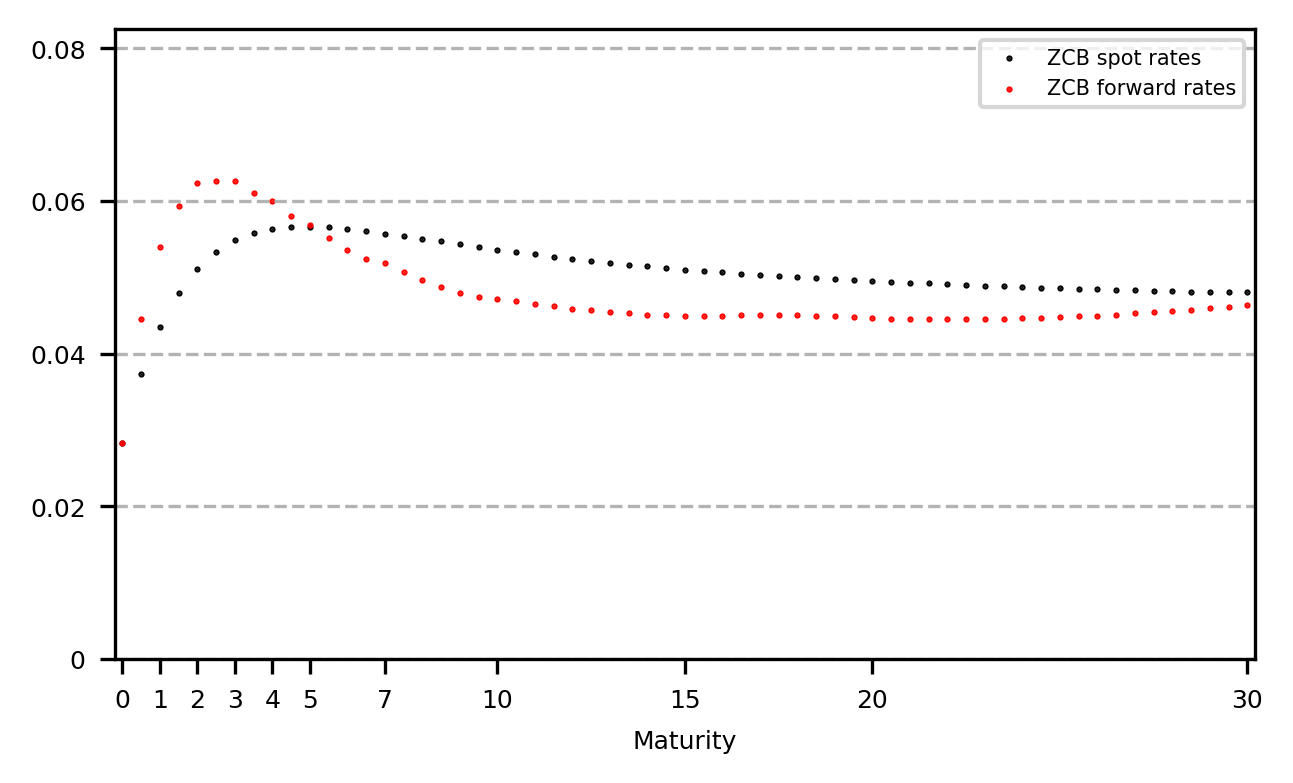

Maturity: 0.5Y, Spot Rate: 0.037369
Maturity: 1Y, Spot Rate: 0.043518
Maturity: 2Y, Spot Rate: 0.051155
Maturity: 5Y, Spot Rate: 0.056656
Maturity: 10Y, Spot Rate: 0.053611
Maturity: 15Y, Spot Rate: 0.051014
Maturity: 20Y, Spot Rate: 0.049545
Maturity: 30Y, Spot Rate: 0.048042
SSE of the fit is: 0.00036680


In [19]:
# 1a) 
interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T = np.array([i*0.5 for i in range(0,61)])
T_fit, R_fit = fid.zcb_curve_fit(data_zcb,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T,T_fit,R_fit,interpolation_options = interpolation_options)

# Plotting 
fig = plt.figure(constrained_layout = False, dpi = 300, figsize = (5,3))
fig.suptitle(f"", fontsize = 10)
gs = fig.add_gridspec(nrows = 1, ncols = 1, left = 0.12, bottom = 0.2, right = 0.88, top = 0.90, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T, R_inter, s = 1, color = 'black', marker = ".",label="ZCB spot rates")
p2 = ax.scatter(T, f_inter, s = 1, color = 'red', marker = ".",label="ZCB forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

# Slicing 
t_maturities = [0.5, 1, 2, 5, 10, 15, 20, 30]
indices = [np.where(T_fit == maturity)[0][0] for maturity in t_maturities]
spot_rates = R_fit[indices]

for maturity, rate in zip(t_maturities, spot_rates):
    print(f"Maturity: {maturity}Y, Spot Rate: {rate:.6f}")

# Extract market maturities and rates
market_maturities = np.array([data["maturity"] for data in data_zcb if "maturity" in data and "rate" in data])
market_rates = np.array([data["rate"] for data in data_zcb if "maturity" in data and "rate" in data])

# Interpolate fitted rates using the Fixed Income Derivatives interpolation function
interpolated_fitted_rates, _ = fid.interpolate(market_maturities, T_fit, R_fit, interpolation_options={"method": "linear"})

# Calculate errors and sum of squared errors (SSE)
errors = market_rates - interpolated_fitted_rates
SSE = np.sum(errors**2)

# Display the result
print(f"SSE of the fit is: {SSE:.8f}")


The par swap rate on a ten year swap is: 0.055390


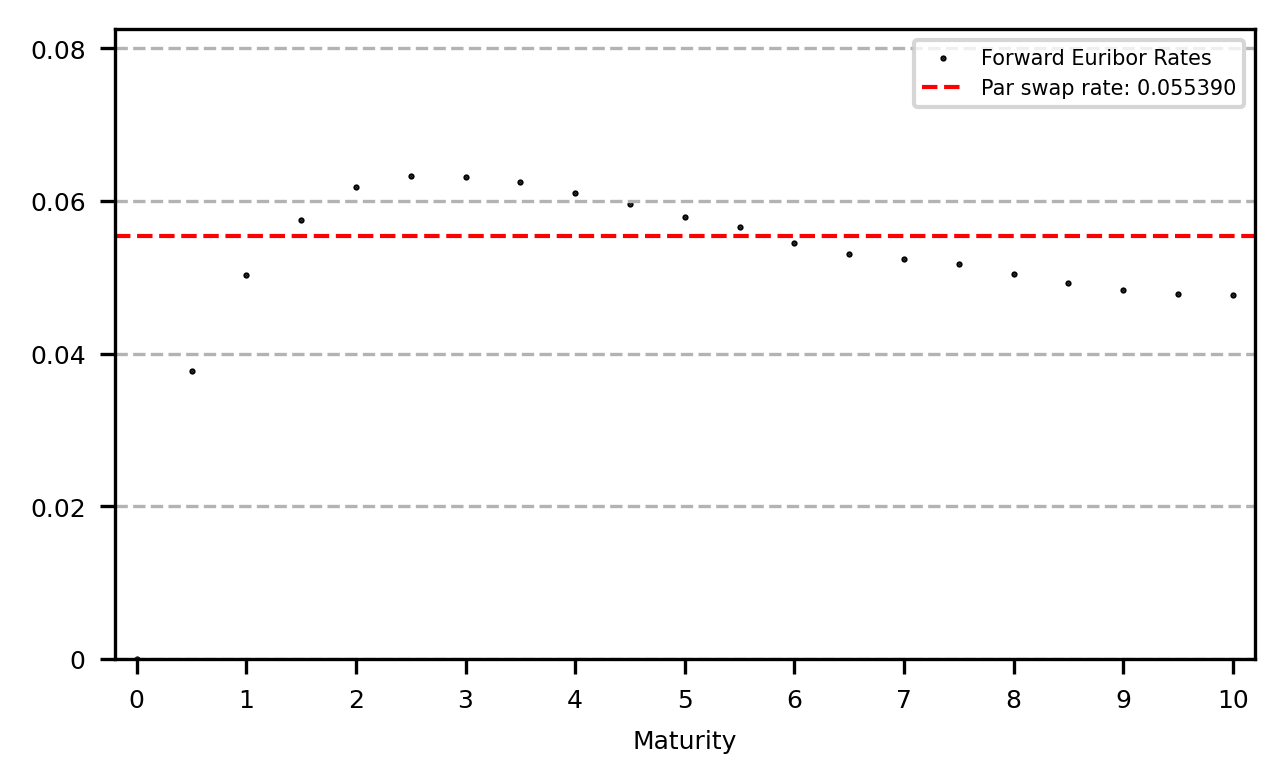

In [20]:
#1c) 
T_1c = np.arange(0, 10.5, 0.5)
f_1c = fid.forward_libor_rates_from_zcb_prices(T_1c, p_inter,1)

swap_1c, acc_fac_1c = fid.swap_rate_from_zcb_prices(0,0,10,"annual", T_1c, p_inter, "semiannual")
print(f"The par swap rate on a ten year swap is: {swap_1c:.6f}")

# Plotting 
fig = plt.figure(constrained_layout = False, dpi = 300, figsize = (5,3))
fig.suptitle(f"", fontsize = 10)
gs = fig.add_gridspec(nrows = 1, ncols = 1, left = 0.12, bottom = 0.2, right = 0.88, top = 0.90, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,6,7,8,9,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_1c, f_1c, s = 1, color = 'black', marker = ".",label="Forward Euribor Rates")
p2 = ax.axhline(y=swap_1c, color='red', linestyle='--', linewidth=1, label=f"Par swap rate: {swap_1c:.6f}")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()



Parameters from the fit without sigma: [0.02779713 5.24371979 0.27114316]. SE of the fit: 0.0006020461592107221


/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_28097/4028493716.py:12: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_vasicek_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R_2a,T_2a),options={'xatol': 1e-20,'disp': True}) # Minimizing the objective function


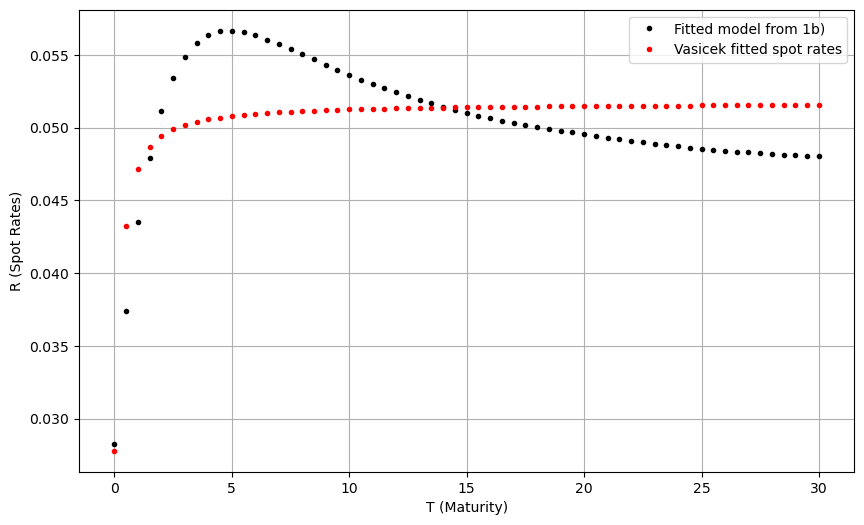

In [21]:
#2a)
T_2a = T_inter
R_2a = R_inter

# Initial values
r0 = 0.035
a = 6 
b = 0.25
sigma = 0.02 # Sigma is a constant

param_0 = r0, a, b # Initial guesses
result = minimize(fid.fit_vasicek_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R_2a,T_2a),options={'xatol': 1e-20,'disp': True}) # Minimizing the objective function
print(f"Parameters from the fit without sigma: {result.x}. SE of the fit: {result.fun}") 
r0_hat, a_hat, b_hat = result.x # Extracting the parameters

R_2a_vasicek = fid.spot_rate_vasicek(r0_hat,a_hat,b_hat, sigma, T_2a) 

plt.figure(figsize=(10, 6))
plt.plot(T_2a, R_2a, '.', label='Fitted model from 1b)', color='black')
plt.plot(T_2a, R_2a_vasicek, '.', label='Vasicek fitted spot rates', color='red')
plt.xlabel('T (Maturity)')
plt.ylabel('R (Spot Rates)')
plt.legend()
plt.grid(True)
plt.show()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 88
         Function evaluations: 175
Parameters: a = 2.230046, sigma = 0.022052
SSE: 0.000000
Caplet prices: [0.         0.         0.00036895 0.00188112 0.00328094 0.00374899
 0.00360752 0.0032627  0.00265172 0.0021214  0.00161367 0.00126785
 0.0008438  0.00060061 0.00050833 0.00042365 0.00029403 0.00020911
 0.00015748 0.00013006 0.0001218 ]


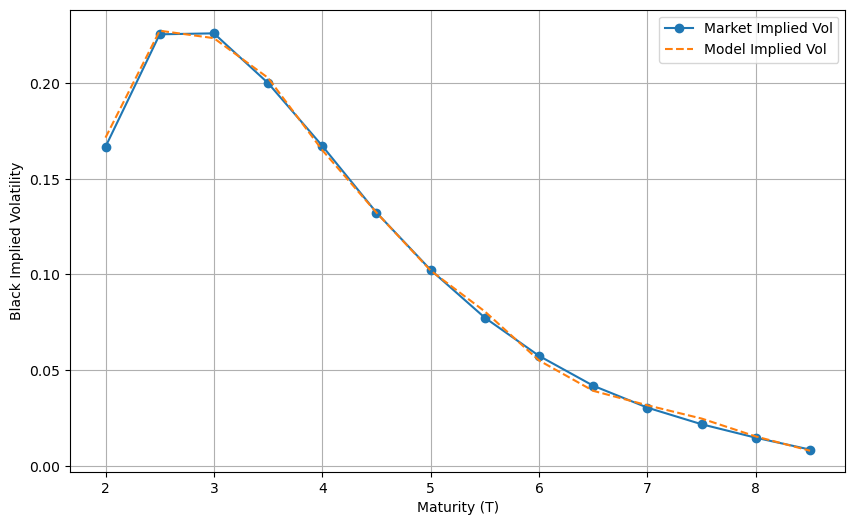

In [31]:
#2b) - If runtime warnings occur. I just run it 3+ times. Typucally, it fixes it.
# Initial values 
a_2b = 2.5
sigma_2b = 0.018

# Creating coupon prices
indices_2b = [np.where(T_2a == t)[0][0] for t in T_caplet]
R_2b = R_2a[indices_2b]
p_2b = fid.zcb_prices_from_spot_rates(T_caplet,R_2b)

# Objective function to mimimize
def objective_hwev(params, T_caplet, p_2b, price_caplet_market, strike_caplet_market):
    a, sigma = params
    # Calc caplet prices
    price_caplet_model = fid.caplet_prices_hwev(strike_caplet_market, a, sigma, T_caplet, p_2b)
    # Computing SSE
    sse = np.sum((price_caplet_market - price_caplet_model) ** 2)
    return sse

# Optimizing using Nelder-Mead
result = minimize(
    objective_hwev,
    x0=[a_2b, sigma_2b],
    args=(T_caplet, p_2b, price_caplet_market, strike_caplet_market),
    method="nelder-mead",
    options={"xatol": 1e-8, "disp": True}
)
# Extracting parameters and SSE
a_HWEV, sigma_HWEV = result.x
sse_HWEV = result.fun

# Printing results
print(f"Parameters: a = {a_HWEV:.6f}, sigma = {sigma_HWEV:.6f}")
print(f"SSE: {sse_HWEV:.6f}")

caplet_prices_2b =fid.caplet_prices_hwev(strike_caplet_market, a_HWEV, sigma_HWEV, T_caplet, p_2b)
print(f"Caplet prices: {caplet_prices_2b}")


# Plotting Black implied volatility term structures
def plot_black_volatility(T_caplet, market_prices, model_prices, strike_rate, R, alpha, p):
    # Computing Black implied volatilities for market and model prices
    market_iv = [fid.black_caplet_iv(C, T, R[i], alpha, p[i], strike_rate) for i, (C, T) in enumerate(zip(market_prices, T_caplet))]
    model_iv = [fid.black_caplet_iv(C, T, R[i], alpha, p[i], strike_rate) for i, (C, T) in enumerate(zip(model_prices, T_caplet))]
    
    plt.figure(figsize=(10, 6))
    plt.plot(T_caplet, market_iv, label="Market Implied Vol", marker="o")
    plt.plot(T_caplet, model_iv, label="Model Implied Vol", linestyle="--")
    plt.xlabel("Maturity (T)")
    plt.ylabel("Black Implied Volatility")
    # plt.title("Term Structure of Black Implied Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_black_volatility(T_caplet, price_caplet_market, caplet_prices_2b, strike_caplet_market, R_2b, alpha_caplet, p_2b)

type_ci: two_sided, z: 1.959963984540054


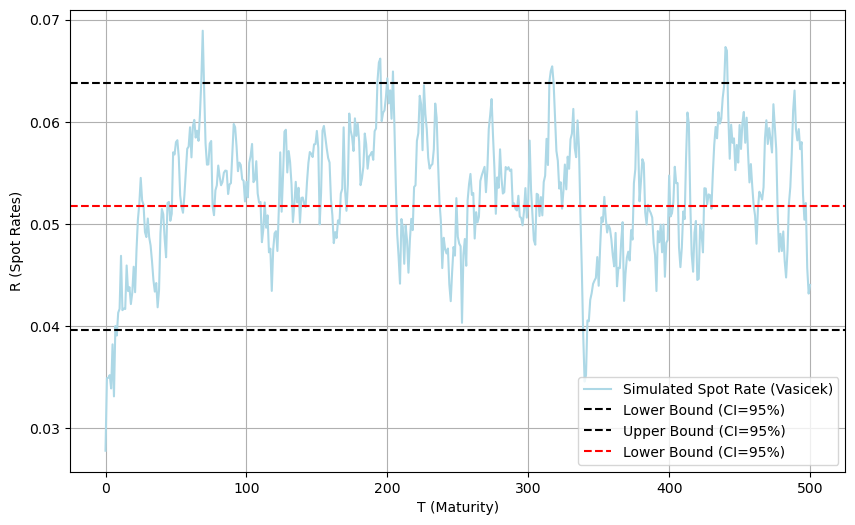

In [23]:
#2c) 
np.random.seed(1)
# Vasicek
T_2c = 10
M_2c = 500
delta_2c = 0.02
ci = 0.95

r_simul_vasicek = fid.simul_vasicek(r0_hat, a_hat, b_hat, sigma, M_2c, T_2c, method="euler")
lb_vasicek, ub_vasicek = fid.ci_vasicek(r0_hat, a_hat, b_hat, sigma, T_2c, ci)
mean_vasicek = fid.mean_vasicek(r0_hat,a_hat,b_hat,sigma, T_2c)

# Plot Vasicek simulation with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(r_simul_vasicek, '-', label='Simulated Spot Rate (Vasicek)', color='lightblue')
plt.axhline(y=lb_vasicek, color='black', linestyle='--', label=f'Lower Bound (CI={ci*100:.0f}%)')
plt.axhline(y=ub_vasicek, color='black', linestyle='--', label=f'Upper Bound (CI={ci*100:.0f}%)')
plt.axhline(y=mean_vasicek, color='red', linestyle='--', label=f'Lower Bound (CI={ci*100:.0f}%)')
plt.xlabel('T (Maturity)')
plt.ylabel('R (Spot Rates)')
plt.legend()
plt.grid(True)
plt.show()


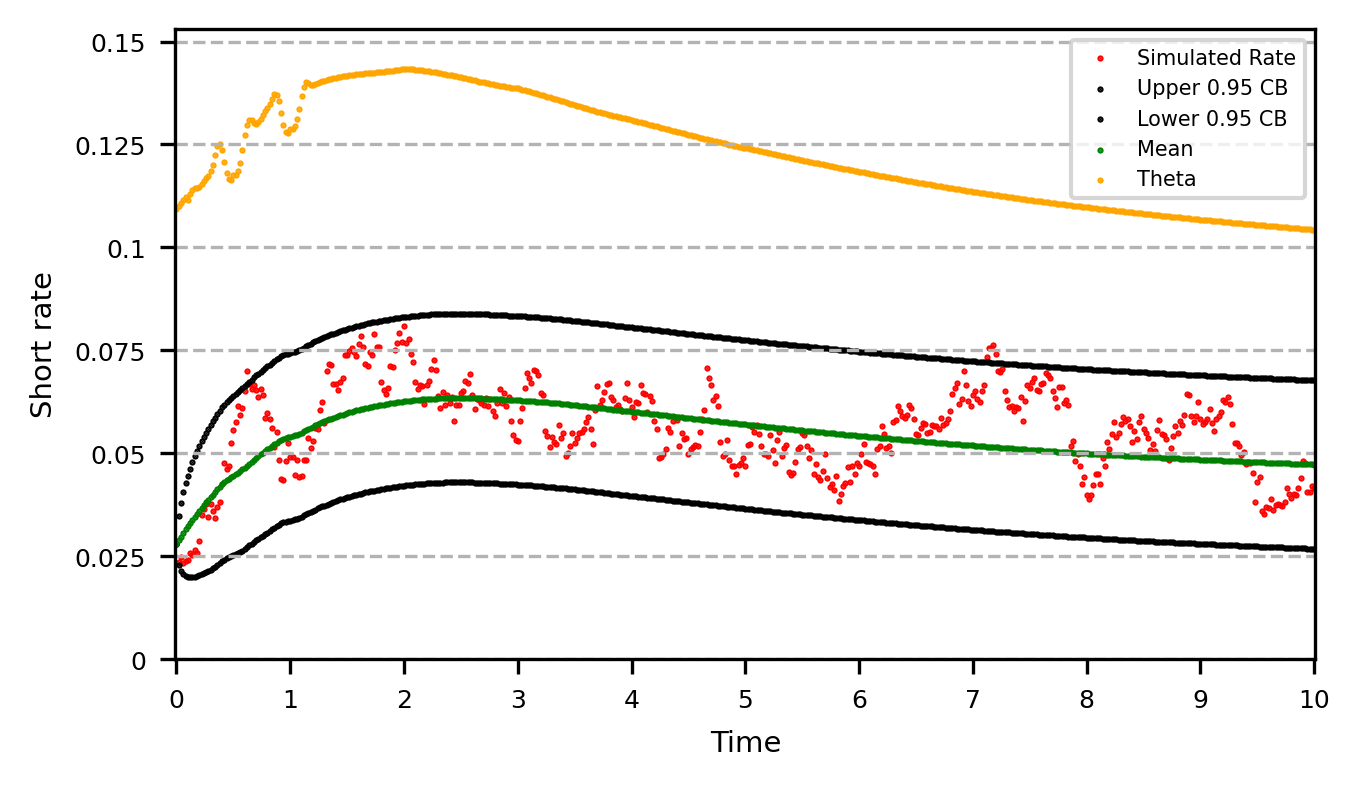

In [24]:
# HWEV
# As stated, we must calibrate again. 
data_2c = EURIBOR_fixing + fra_market + swap_market
mesh = 1/12
M_2c = 500
T_2c = np.array([mesh*i for i in range(0,M_2c+1)])
interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit_2c, R_fit_2c = fid.zcb_curve_fit(data_2c,interpolation_options = interpolation_options)
p_inter_2c, R_inter_2c, f_inter_2c, T_inter_2c = fid.zcb_curve_interpolate(T_2c,T_fit_2c,R_fit_2c,interpolation_options = interpolation_options)
f_fit_2c = np.array(fid.for_values_in_list_find_value_return_value(T_fit_2c,T_inter_2c,f_inter_2c))
f_star_2c, f_T_star_2c = fid.interpolate(T_2c,T_fit_2c,f_fit_2c,interpolation_options)

M_2c, T_2c = 500, 10
size_ci_2c = 0.95
mesh_2c = T_2c/M_2c
t_2c = np.array([i*mesh_2c for i in range(0,M_2c+1)])
f_2c, f_T_2c = fid.interpolate(t_2c,T_fit_2c,f_fit_2c,interpolation_options)
theta_2c = fid.theta_hwev(t_2c,f_2c,f_T_2c,a_HWEV,sigma_HWEV)
r_2c = fid.simul_hwev(f_2c[0],t_2c,theta_2c,a_HWEV,sigma_HWEV,method = "euler")
mean_hwev_2c, var_hwev_2c = fid.mean_var_hwev(a_HWEV,sigma_HWEV,t_2c,f_2c,f_T_2c)
lb_2c, ub_2c = fid.ci_hwev(a_HWEV,sigma_HWEV,t_2c,f_2c,f_T_2c,size_ci_2c,type_ci = "two_sided")

fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,6,7,8,9,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15] 
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_2c, r_2c, s = 1, color = 'red', marker = ".",label="Simulated Rate")
p2 = ax.scatter(t_2c, ub_2c, s = 1, color = 'black', marker = ".",label=f"Upper {ci} CB")
p3 = ax.scatter(t_2c, lb_2c, s = 1, color = 'black', marker = ".",label=f"Lower {ci} CB")
p4 = ax.scatter(t_2c, mean_hwev_2c, s = 1, color = 'green', marker = ".",label=f"Mean")
p5 = ax.scatter(t_2c, theta_2c, s = 1, color = 'orange', marker = ".",label=f"Theta")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)


In [25]:
#2d
T_cap_2d = [0.5 * i for i in range(0, 21)] 
price_caplet_2d=fid.caplet_prices_hwev(0.06,a_HWEV,sigma_HWEV,T_cap_2d,p_2b[0:21])
PV_cap_2d = np.sum(price_caplet_2d)

# Making a DataFrame 
caplet_table = pd.DataFrame({
    "Maturity (T)": T_cap_2d,
    "Caplet Price": price_caplet_2d
})
print(caplet_table.to_string(index=False))

print(f"Price of the cap {PV_cap_2d *10000}")

T_premium_2d = np.array([i*0.5 for i in range(0,20 + 1)])
p_premium_2d = np.array(fid.for_values_in_list_find_value_return_value(T_premium_2d, T_inter_2c, p_inter_2c))
premium_2d = PV_cap_2d / np.sum(p_premium_2d)
print(f"Semiannual premium: {premium_2d*10000}")



 Maturity (T)  Caplet Price
          0.0      0.000000
          0.5      0.000000
          1.0      0.000070
          1.5      0.000712
          2.0      0.001611
          2.5      0.001985
          3.0      0.001903
          3.5      0.001668
          4.0      0.001251
          4.5      0.000918
          5.0      0.000628
          5.5      0.000452
          6.0      0.000258
          6.5      0.000164
          7.0      0.000132
          7.5      0.000104
          8.0      0.000064
          8.5      0.000041
          9.0      0.000029
          9.5      0.000022
         10.0      0.000021
Price of the cap 120.32076063366023
Semiannual premium: 7.4313334943775935


In [26]:
#3a
#Initial values
K_swaption_offset = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])
iv_swaption_market = np.array([0.220675, 0.18331, 0.155103, 0.129001, 0.10812, 0.084411, 0.071866, 0.066535, 0.073942, 0.082751, 0.093605, 0.098971, 0.108909])
R_ATM = 0.071866

interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_3a = np.arange(0, 10.5, 0.5)
T_fit_3a, R_fit_3a = fid.zcb_curve_fit(data_zcb,interpolation_options = interpolation_options)
p_inter_3a, R_inter_3a, f_inter_3a, T_inter_3a = fid.zcb_curve_interpolate(T_3a,T_fit_3a,R_fit_3a,interpolation_options = interpolation_options)

swap_rate_3a, accrual_rate_3a =fid.swap_rate_from_zcb_prices(0, 3, 10, "annual", T_3a, p_inter_3a, "semiannual")
print(f"Swap-rate: {swap_rate_3a}")
print(f"Accrual: {accrual_rate_3a}")

# Converting strikes to decimals
target_3a = 0.06
K_swaption = swap_rate_3a + K_swaption_offset / 10000  
print(K_swaption)

sigma = 0.066535

price = fid.black_swaption_price(sigma, T=3, K=target_3a, S=accrual_rate_3a, R=swap_rate_3a, type="call")
print(f"Swaption Price: {price*10000}")

Swap-rate: 0.05503346157480673
Accrual: 4.7834884870986665
[0.02503346 0.03003346 0.03503346 0.04003346 0.04503346 0.05003346
 0.05503346 0.06003346 0.06503346 0.07003346 0.07503346 0.08003346
 0.08503346]
Swaption Price: 41.527602064605304


Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 111
         Function evaluations: 205


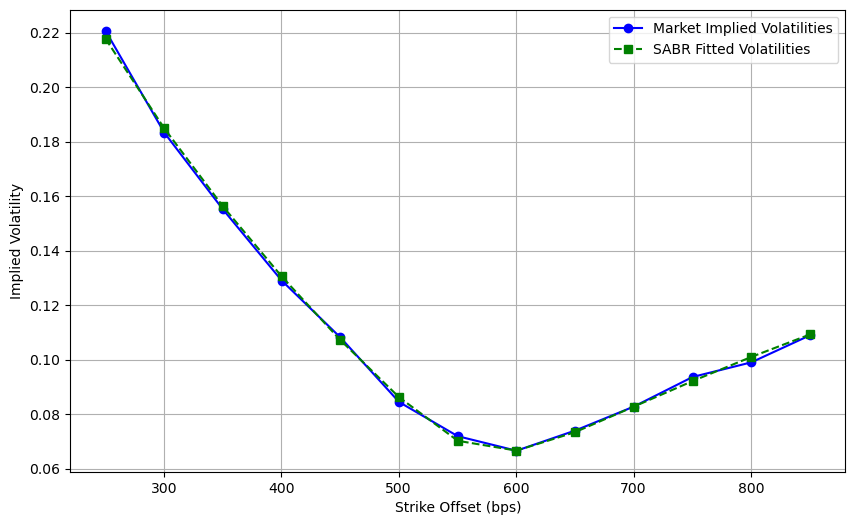

Sigma: 0.018
Upsilon: 0.584
Rho: -0.344
SSE: 0.000028


In [27]:
#3b
# Creating a new function, since we know that beta is fixed 
def fit_sabr_obj_beta(param, sigma_market, K, T, R, beta):
    sigma_0, upsilon, rho = param  
    N = len(sigma_market)
    sse = 0
    for n in range(N):
        sigma_model = fid.sigma_sabr(K[n], T, R, sigma_0, beta, upsilon, rho, type="call")
        sse += (sigma_market[n] - sigma_model) ** 2
    return sse

beta = 0.55
param_0 = 0.025, 0.48, -0.25
K_offsets = swap_rate_3a + K_swaption_offset / 10000

result = minimize(fit_sabr_obj_beta,param_0,method = 'nelder-mead',args = (iv_swaption_market,K_offsets,3,swap_rate_3a,beta),options={'xatol': 1e-8,'disp': True}) # Minimzing using SABR objective function
# Extracting parameters
sigma_0_tilde_3b, upsilon_tilde_3b, rho_tilde_3b = result.x 
SSE_3b = result.fun

iv_3b = []
for i, K_i in enumerate(K_offsets):
    sigmas = fid.sigma_sabr(K_i, 3, swap_rate_3a, sigma_0_tilde_3b, beta, upsilon_tilde_3b, rho_tilde_3b)
    iv_3b.append(sigmas)

# Converting in order to plot 
black_iv_3b = np.array(iv_3b)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_swaption * 10000, iv_swaption_market, marker='o', linestyle='-', color='blue', label='Market Implied Volatilities')
plt.plot(K_swaption * 10000, black_iv_3b, marker='s', linestyle='--', color='green', label='SABR Fitted Volatilities')
plt.xlabel("Strike Offset (bps)")
plt.ylabel("Implied Volatility")
# plt.title("Market Implied Volatilities of 3Y7Y Payer Swaptions")
plt.legend()
plt.grid(True)
plt.show()
print(f"Sigma: {sigma_0_tilde_3b:.3f}")
print(f"Upsilon: {upsilon_tilde_3b:.3f}")
print(f"Rho: {rho_tilde_3b:.3f}")
print(f"SSE: {SSE_3b:.6f}")



In [28]:
def calculate_strangle_value(F0, sigma_0, swap_rate, K_plus, K_minus, accrual_rate, beta, upsilon_tilde, rho_tilde):
    sigma_plus = fid.sigma_sabr(K_plus, 3, F0, sigma_0, beta, upsilon_tilde, rho_tilde)
    sigma_minus = fid.sigma_sabr(K_minus, 3, F0, sigma_0, beta, upsilon_tilde, rho_tilde)
    price_call = fid.black_swaption_price(sigma_plus, T=3, K=K_plus, S=accrual_rate, R=F0, type="call")
    price_put = fid.black_swaption_price(sigma_minus, T=3, K=K_minus, S=accrual_rate, R=F0, type="put")
    return price_call + price_put

# Defining strikes 
K_plus = swap_rate_3a + 100 / 10000  
K_minus = swap_rate_3a - 100 / 10000  

# Strangle Value
strangle_value = calculate_strangle_value(swap_rate_3a, sigma_0_tilde_3b, swap_rate_3a, K_plus, K_minus, accrual_rate_3a, beta, upsilon_tilde_3b, rho_tilde_3b)
print(f"Strangle Value: {strangle_value:.8f}")

# Bumping values
bump_values = {
    "F0_up": swap_rate_3a + 0.0001,
    "F0_down": swap_rate_3a - 0.0001,
    "sigma_0_up": sigma_0_tilde_3b + 0.001,
    "sigma_0_down": sigma_0_tilde_3b - 0.001
}

# Computing strangle values for bumped F0
for bump, F0 in {"up": bump_values["F0_up"], "down": bump_values["F0_down"]}.items():
    strangle_value_bumped = calculate_strangle_value(F0, sigma_0_tilde_3b, swap_rate_3a, K_plus, K_minus, accrual_rate_3a, beta, upsilon_tilde_3b, rho_tilde_3b)
    print(f"Strangle Value F0 {bump}: {strangle_value_bumped:.8f}")

# Computing strangle values for bumped sigma_0
for bump, sigma_0 in {"up": bump_values["sigma_0_up"], "down": bump_values["sigma_0_down"]}.items():
    strangle_value_bumped_sigma = calculate_strangle_value(swap_rate_3a, sigma_0, swap_rate_3a, K_plus, K_minus, accrual_rate_3a, beta, upsilon_tilde_3b, rho_tilde_3b)
    print(f"Strangle Value sigma_0 {bump}: {strangle_value_bumped_sigma:.8f}")


Strangle Value: 0.00474746
Strangle Value F0 up: 0.00474821
Strangle Value F0 down: 0.00474784
Strangle Value sigma_0 up: 0.00536019
Strangle Value sigma_0 down: 0.00416857


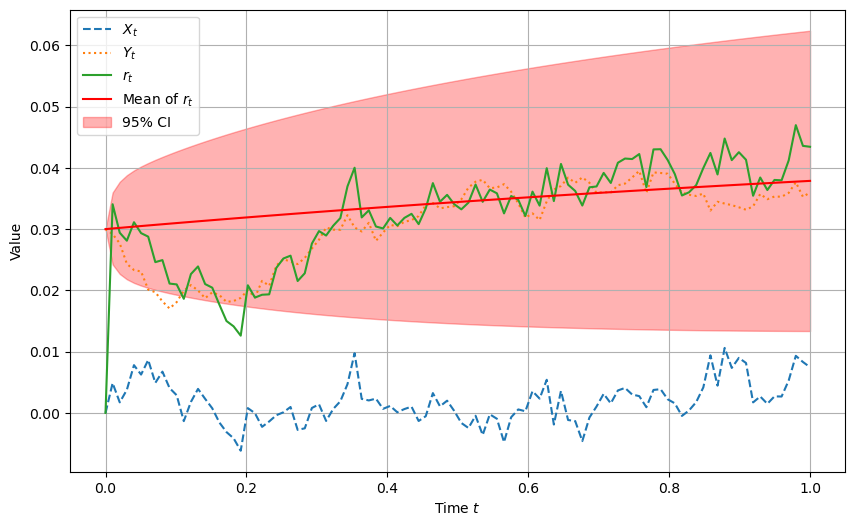

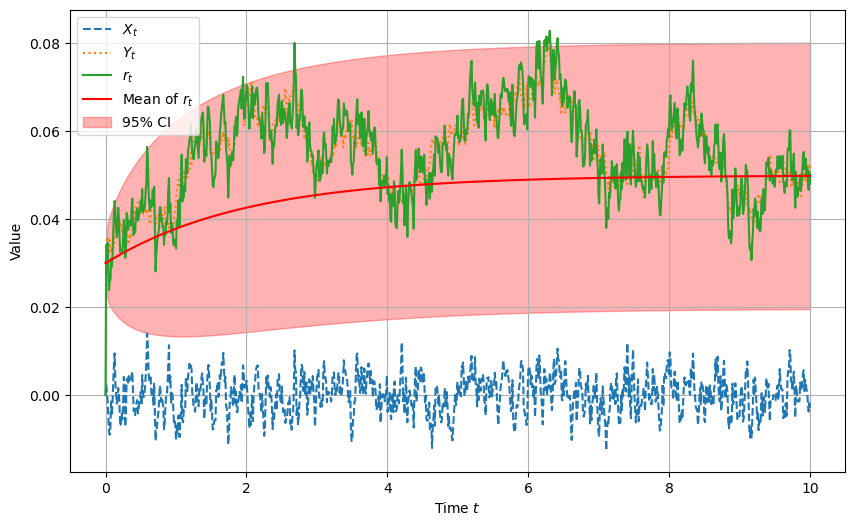

Confidence intervals for T=1: (0.013366280344952366, 0.0623724932665423)
Confidence intervals for T=10: (0.019561062171345026, 0.08016941994869156)


In [29]:
#5c
# Initial values 
x0 = 0
gamma = 32
phi = 0.03
y0 = 0.03
a = 0.5
b = 0.025
sigma = 0.015
delta = 0.01 

# Time grid for T=1 and T=10
T1, N1 = 1, 100
T2, N2 = 10, 1000
t1 = np.linspace(0, T1, N1)
t2 = np.linspace(0, T2, N2)

# Mean and Variance dynamics for X_t and Y_t
def mean_X(x0, gamma, t):
    return x0 * np.exp(-gamma * t)

def variance_X(phi, gamma, t):
    return (phi**2 / (2 * gamma)) * (1 - np.exp(-2 * gamma * t))

def mean_Y(y0, a, b, t):
    return y0 * np.exp(-a * t) + (b / a) * (1 - np.exp(-a * t))

def variance_Y(sigma, a, t):
    return (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * t))

def mean_r(x0, y0, gamma, a, b, t):
    return mean_X(x0, gamma, t) + mean_Y(y0, a, b, t)

def variance_r(phi, gamma, sigma, a, t):
    return variance_X(phi, gamma, t) + variance_Y(sigma, a, t)

# Simulating a trajectory for T=1
np.random.seed(1) 
X1 = np.zeros(N1)
Y1 = np.zeros(N1)
r1 = np.zeros(N1)

X1[0] = x0
Y1[0] = y0

for i in range(1, N1):
    dW1 = np.random.normal(0, np.sqrt(delta))
    dW2 = np.random.normal(0, np.sqrt(delta))

    X1[i] = X1[i-1] - gamma * X1[i-1] * delta + phi * dW1
    Y1[i] = Y1[i-1] + (b - a * Y1[i-1]) * delta + sigma * dW2
    r1[i] = X1[i] + Y1[i]

# Simulating a trajectory for T=10
X2 = np.zeros(N2)
Y2 = np.zeros(N2)
r2 = np.zeros(N2)

X2[0] = x0
Y2[0] = y0

for i in range(1, N2):
    dW1 = np.random.normal(0, np.sqrt(delta))
    dW2 = np.random.normal(0, np.sqrt(delta))

    X2[i] = X2[i-1] - gamma * X2[i-1] * delta + phi * dW1
    Y2[i] = Y2[i-1] + (b - a * Y2[i-1]) * delta + sigma * dW2
    r2[i] = X2[i] + Y2[i]

# Mean and confidence intervals
mean_r1 = mean_r(x0, y0, gamma, a, b, t1)
mean_r2 = mean_r(x0, y0, gamma, a, b, t2)

variance_r1 = variance_r(phi, gamma, sigma, a, t1)
variance_r2 = variance_r(phi, gamma, sigma, a, t2)

ci_upper1 = mean_r1 + 1.96 * np.sqrt(variance_r1)
ci_lower1 = mean_r1 - 1.96 * np.sqrt(variance_r1)

ci_upper2 = mean_r2 + 1.96 * np.sqrt(variance_r2)
ci_lower2 = mean_r2 - 1.96 * np.sqrt(variance_r2)

# Plot for T=1
plt.figure(figsize=(10, 6))
plt.plot(t1, X1, label='$X_t$', linestyle='--')
plt.plot(t1, Y1, label='$Y_t$', linestyle=':')
plt.plot(t1, r1, label='$r_t$', linewidth=1.5)
plt.plot(t1, mean_r1, color='red', linestyle='-', label='Mean of $r_t$')
plt.fill_between(t1, ci_lower1, ci_upper1, color='red', alpha=0.3, label='95% CI')
plt.xlabel('Time $t$')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Plot for T=10
plt.figure(figsize=(10, 6))
plt.plot(t2, X2, label='$X_t$', linestyle='--')
plt.plot(t2, Y2, label='$Y_t$', linestyle=':')
plt.plot(t2, r2, label='$r_t$', linewidth=1.5)
plt.plot(t2, mean_r2, color='red', linestyle='-', label='Mean of $r_t$')
plt.fill_between(t2, ci_lower2, ci_upper2, color='red', alpha=0.3, label='95% CI')
plt.xlabel('Time $t$')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

ci_T1 = (ci_lower1[-1], ci_upper1[-1])
ci_T10 = (ci_lower2[-1], ci_upper2[-1])

print(f"Confidence intervals for T=1: {ci_T1}")
print(f"Confidence intervals for T=10: {ci_T10}")